In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
FIG_PREFIX = 'WebLarge'

In [3]:
root_dir = '../result/dbplLarge1000_result_new'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [4]:
def build_stats_filename(row):
    name = row['name']
    if 'parallel' in name:
        name = name.split('-')[0]
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity']), 'stats.csv']
    return '_'.join(fields)

In [5]:
def get_stats_df(row):
    fname = build_stats_filename(row)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t')

In [6]:
summary_path = os.path.join(root_dir, 'summary.csv')
summary_df = pd.read_csv(summary_path)

In [7]:
summary_df.ffill(inplace=True)
summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']

In [8]:
# code for getting end-to-end trimmed mean
res = summary_df.sort_values('overall_time')
res = res.drop(res.groupby(by=id_cols).tail(1).index)
res = res.drop(res.groupby(by=id_cols).head(1).index)

In [9]:
res_df = res.groupby(by=id_cols, as_index=False).mean(numeric_only=True).apply(lambda x: x)

In [10]:
def add_num_after_filter(df):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': []
    }
    
    for _, row in df.iterrows():
        detail_df = get_stats_df(row)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        # if detail_df['count'].sum() != 368166:
        # print(build_stats_filename(row))
        # print(detail_df)
    return df.assign(**new_cols)

In [ ]:
res_df = add_num_after_filter(res_df)
res_df.describe()

In [25]:
res_df[res_df['num_threads'] > 1].head(10)

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count
25,FREE-parallel,2.0,2.0,0.01,2016.0,7.61812,4.19216,11.8103,28588398.0,0.030072,472.091454,472.121526,483.931826,1114068252,1114068.252,4426419
26,FREE-parallel,2.0,2.0,0.02,2035.0,7.52856,4.37966,11.9082,53430226.0,0.011750,380.327768,380.339518,392.247718,826861950,826861.950,4426419
27,FREE-parallel,2.0,2.0,0.03,2001.0,7.71133,4.44507,12.1564,75966106.0,0.031505,318.299335,318.330840,330.487240,628049696,628049.696,4426419
28,FREE-parallel,2.0,2.0,0.05,2048.0,7.76471,4.79782,12.5625,138045232.0,0.030527,203.510198,203.540726,216.103226,284577708,284577.708,4426419
29,FREE-parallel,2.0,2.0,0.07,2075.0,7.68466,5.00348,12.6881,187880330.0,0.012420,142.943361,142.955781,155.643881,98606607,98606.607,4426419
30,FREE-parallel,2.0,2.0,0.10,2034.0,7.70439,5.18950,12.8939,240553424.0,0.012851,132.261278,132.274129,145.168029,53125490,53125.490,4426419
31,FREE-parallel,2.0,2.0,0.12,2020.0,7.69116,5.27622,12.9674,265823270.0,0.012587,132.217659,132.230246,145.197646,51051480,51051.480,4426419
32,FREE-parallel,2.0,2.0,0.15,1775.0,7.61143,5.30857,12.9200,322779876.0,0.012750,122.188238,122.200988,135.120988,22801514,22801.514,4426419
33,FREE-parallel,2.0,2.0,0.20,1665.0,7.71128,5.40688,13.1182,361245756.0,0.012775,124.170201,124.182975,137.301175,20629819,20629.819,4426419
34,FREE-parallel,2.0,2.0,0.30,1224.0,7.70621,5.13618,12.8424,379461828.0,0.031246,121.198807,121.230053,134.072453,20442830,20442.830,4426419


[2. 4. 6.]


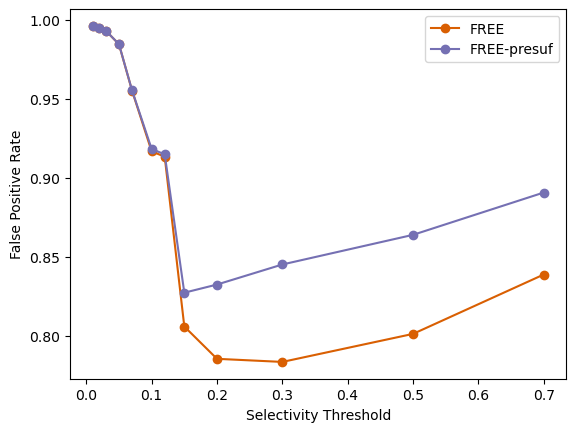

In [26]:
# gram size vs accuracy
temp_g = res_df[res_df['num_threads'] == 1]
colors = ['#1b9e77','#d95f02','#7570b3']
# for i, name in enumerate(['BEST', 'FREE']):
#     ax = plt.subplot()
#     temp = temp_g[temp_g['name'].str.contains(name)]
#     x = temp['selectivity']
#     y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
#     x, y = zip(*sorted(zip(x, y)))
#     print(temp)
#     ax.plot(x, y, label=name, c=colors[i]) 
#     plt.xlabel('Max Gram Size')
#     plt.ylabel('False Positive Rate')
#     plt.legend()
#     plt.savefig(f'figs/{FIG_PREFIX}_sel_false_positive.pdf', bbox_inches='tight')

#     plt.show()

# # BEST
# ax = plt.subplot()
# temp = temp_g[temp_g['name'].str.contains('BEST')]
# x = temp['selectivity']
# y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
# # x, y = zip(*sorted(zip(x, y)))
# # print(temp)
# ax.plot(x, y, marker='o', label='BEST', c=colors[0]) 
# plt.xlabel('Selectivity Threshold')
# plt.ylabel('False Positive Rate')
# plt.legend()
# plt.savefig(f'figs/{FIG_PREFIX}_best_sel_vs_fp.pdf', bbox_inches='tight')
# plt.show()

print(temp_g['gram_size'].unique())

# FREE
ax = plt.subplot()
temp = temp_g[(temp_g['name'] == ('FREE')) & (temp_g['gram_size'] == 2)]
x = temp['selectivity']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
x, y = zip(*sorted(zip(x, y)))
ax.plot(x, y, marker='o', label='FREE', c=colors[1]) 

temp = temp_g[(temp_g['name'].str.contains('FREE-presuf')) & (temp_g['gram_size'] == 2)]
x = temp['selectivity']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
x, y = zip(*sorted(zip(x, y)))
ax.plot(x, y, marker='o', label='FREE-presuf', c=colors[2]) 

plt.xlabel('Selectivity Threshold')
plt.ylabel('False Positive Rate')
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_free_sel_vs_fp.pdf', bbox_inches='tight')
plt.show()

In [ ]:
best_df = res_df[res_df['name'].str.contains('BEST')]

In [29]:
free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]

In [30]:
# free with c = 0.1, plot false positive rate against gramsize 
# free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]
temp_free = free_df[free_df['selectivity'] == 0.1]

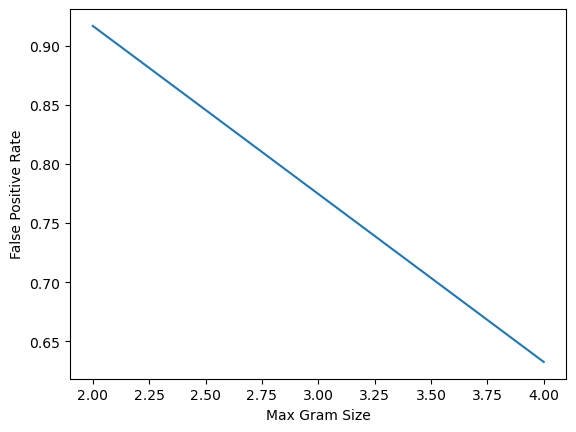

In [32]:
# gram size vs accuracy
temp = temp_free[temp_free['num_threads'] == 1]
ax = plt.subplot()
x = temp['gram_size']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
ax.plot(x, y) 
plt.xlabel('Max Gram Size')
plt.ylabel('False Positive Rate')
plt.show()

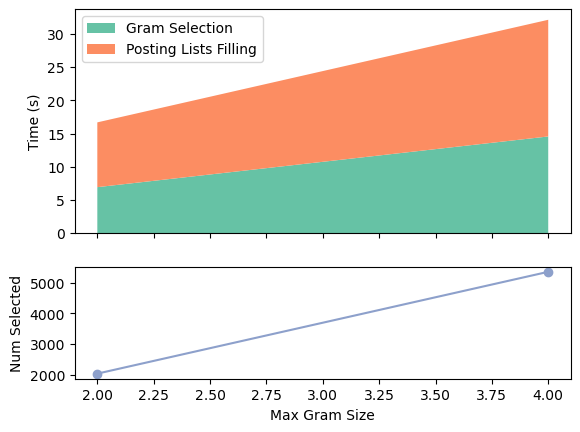

In [33]:
# gram size vs index size; gram size vs index build time
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

colors = ['#66c2a5','#fc8d62','#8da0cb']

temp = temp_free[temp_free['num_threads'] == 1]
x = temp['gram_size']
y_1 = temp['overall_index_time']
y_1_1 = temp['selection_time']
y_1_2 = temp['build_time']

y_2 = temp['num_keys']

axs[0].stackplot(x, y_1_1, y_1_2, labels=[
    'Gram Selection', 'Posting Lists Filling' #, 'Overall Index Construction'
],
    colors=colors[:-1])

# axs[0].plot(x, y_1, label='Overall Index Construction') 
# axs[0].plot(x, y_1_1, label='Gram Selection') 
# axs[0].plot(x, y_1_2, label='Posting Lists Filling') 
axs[0].set_ylabel('Time (s)')
axs[0].legend(loc='upper left')

axs[1].plot(x, y_2, marker='o', c=colors[-1])
axs[1].set_ylabel('Num Selected')

plt.xlabel('Max Gram Size')
plt.savefig(f'figs/{FIG_PREFIX}free_n_vs_index-time_num-keys.pdf', bbox_inches='tight')

plt.show()

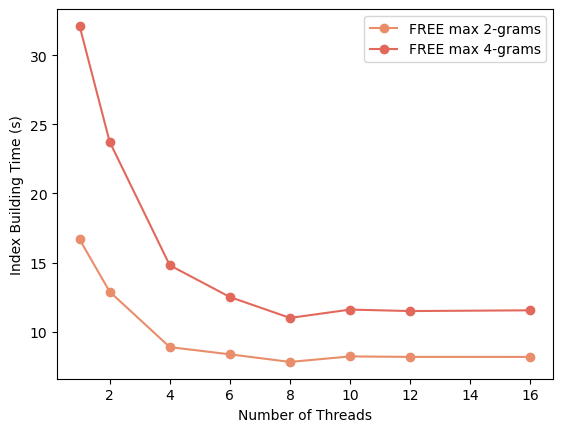

In [34]:
# thread vs. build time; label by gram size
ax = plt.subplot()
seq_colors = sns.color_palette("flare")#, as_cmap=True)
for i, gram_size in enumerate(temp_free['gram_size'].unique()):
    temp = temp_free[temp_free['gram_size'] == gram_size]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='FREE max {}-grams'.format(int(gram_size)), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}free_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

NameError: name 'best_df' is not defined

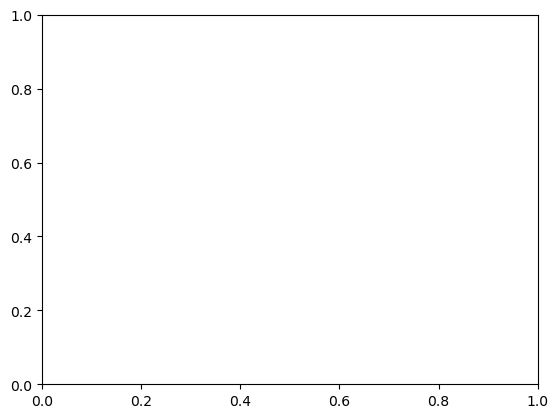

In [35]:
# thread vs. build time; label by gram size
# temp_best = best_df[best_df['selectivity'] == 0.05]
# print(temp_best)
ax = plt.subplot()
seq_colors = sns.color_palette("crest")#, n_colors=11)#, as_cmap=True)
# for i, sel in enumerate(best_df['selectivity'].unique()):
for i, sel in enumerate([0.01, 0.05,0.1, 0.2]):
    temp = best_df[best_df['selectivity'] == sel]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='BEST c <= {}'.format(sel), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}_best_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()